Takes the skimmed parquet files (output of bbVVSkimmer) and evaluates the HWW Tagger.

Author(s): Raghav Kansal

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)
hep.style.use("CMS")

import os
from os import listdir
from os.path import exists
import pickle

import utils
from sample_labels import samples, sig_key

MAIN_DIR = "../../../"

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
plot_dir = f"{MAIN_DIR}/plots/TaggerAnalysis/23Jan31"
os.mkdir(plot_dir)

# samples_dir = f"{MAIN_DIR}/../data/skimmer/Jan20_2"
samples_dir = f"/eos/uscms/store/user/cmantill/bbVV/skimmer/Jan30/"

year = "2017"

In [28]:
# events_dict = utils.load_samples(samples_dir, {sig_key: samples[sig_key]}, year)
events_dict["HHbbVV"] = pd.read_parquet("../../../0-1.parquet")

In [29]:
# (column name, number of subcolumns)
save_columns = [
    ("weight", 1),
    ("ak8FatJetPt", 2),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetParTMD_THWW4q", 2),
    ("ak8FatJetParticleNet_Th4q", 2),
]

### Signal Processing

In [30]:
events = events_dict[sig_key]

# get 4-vectors
vec_keys = ["ak8FatJet", "GenHiggs", "Genbb", "GenVV", "Gen4q"]
vectors = {vec_key: utils.make_vector(events, vec_key) for vec_key in vec_keys}

is_HVV = utils.getParticles(utils.get_feat(events, "GenHiggsChildren"), "V")
is_Hbb = utils.getParticles(utils.get_feat(events, "GenHiggsChildren"), "b")

genHVV = vectors["GenHiggs"][is_HVV]
genHbb = vectors["GenHiggs"][is_Hbb]

masks = (vectors["ak8FatJet"][:, 0].deltaR(genHVV) < vectors["ak8FatJet"][:, 1].deltaR(genHVV))
masks = np.stack([masks, ~masks]).T
# dR = 1.0
# masks = np.stack([vectors["ak8FatJet"][:, i].deltaR(genHVV) < dR for i in range(2)]).T

In [31]:
sig_dict = {}

for column, num_idx in save_columns:
    if num_idx == 1:
        sig_dict[column] = np.tile(events[column].values, 2)[masks]
    else:
        sig_dict[column] = np.nan_to_num(events[column].values[masks], copy=True, nan=0)

events_dict[sig_key] = sig_dict

### Background Processing

In [9]:
full_samples_list = listdir(f"{samples_dir}/{year}")

# reformat into ("column name", "idx") format for reading multiindex columns
bg_column_labels = []
for key, num_columns in save_columns:
    for i in range(num_columns):
        bg_column_labels.append(f"('{key}', '{i}')")


# bg_keys = ["TT", "QCD"]
bg_keys = ["QCD"]

for bg_key in bg_keys:
    events_dict[bg_key] = {}
    for sample in full_samples_list:
        if bg_key not in sample:
            continue

        if "HH" in sample or "GluGluH" in sample:
            continue

        if not exists(f"{samples_dir}/{year}/{sample}/parquet"):
            print(f"No parquet file for {sample}")
            continue

        print(sample)

        with utils.timer():
            events = pd.read_parquet(
                f"{samples_dir}/{year}/{sample}/parquet",
                columns=bg_column_labels,
            )

        pickles_path = f"{samples_dir}/{year}/{sample}/pickles"
        n_events = utils.get_nevents(pickles_path, year, sample)
        events["weight"] /= n_events

        for var, num_idx in save_columns:
            if num_idx == 1:
                values = np.tile(events[var].values, 2).reshape(-1)
            else:
                values = np.reshape(events[var].values, -1)

            if var in events_dict[bg_key]:
                events_dict[bg_key][var] = np.concatenate(
                    (events_dict[bg_key][var], values), axis=0
                )
            else:
                events_dict[bg_key][var] = values


QCD_HT1000to1500
Time taken: 1.4119409039849415 seconds
QCD_HT100to200
Time taken: 0.9437124020187184 seconds
QCD_HT1500to2000
Time taken: 1.3895390779944137 seconds
QCD_HT2000toInf
Time taken: 0.8849998019868508 seconds
QCD_HT200to300
Time taken: 0.5051426000427455 seconds
QCD_HT300to500
Time taken: 1.5293765249662101 seconds
QCD_HT500to700
Time taken: 1.115851562935859 seconds
QCD_HT50to100
Time taken: 0.40909566008485854 seconds
QCD_HT700to1000
Time taken: 1.449925799970515 seconds


In [25]:
# print weighted sample yields
for sample in events_dict:
    tot_weight = np.sum(events_dict[sample]["weight"])
    print(f"Pre-selection {sample} yield: {tot_weight:.2f}")

Pre-selection HHbbVV yield: 204436.61
Pre-selection QCD yield: 357078392.55


### Cuts

In [33]:
"""
``cuts_dict`` will be of format:
{
    sample1: {
        "cut1var1_min_max_cut1var2...": cut1,
        "cut2var2...": cut2,
        ...
    },
    sample2...
}
"""
pt_key = "Pt"
msd_key = "Msd"
var_prefix = "ak8FatJet"

cutvars_dict = {"Pt": "pt", "Msd": "msoftdrop"}

all_cuts = [
    {pt_key: [300, 1500], msd_key: [20, 320]},
    {pt_key: [400, 600], msd_key: [60, 150]},
    # {pt_key: [300, 1500], msd_key: [110, 140]},
]

var_labels = {pt_key: "pT", msd_key: "mSD"}

cuts_dict = {}
cut_labels = {}  # labels for plot titles, formatted as "var1label: [min, max] var2label..."

for sample, events in events_dict.items():
    # print(sample)
    cuts_dict[sample] = {}
    for cutvars in all_cuts:
        cutstrs = []
        cutlabel = []
        cuts = []
        for cutvar, (cutmin, cutmax) in cutvars.items():
            cutstrs.append(f"{cutvars_dict[cutvar]}_{cutmin}_{cutmax}")
            cutlabel.append(f"{var_labels[cutvar]}: [{cutmin}, {cutmax}]")
            cuts.append(events[f"{var_prefix}{cutvar}"] >= cutmin)
            cuts.append(events[f"{var_prefix}{cutvar}"] < cutmax)

        cutstr = "_".join(cutstrs)
        cut = np.prod(cuts, axis=0)
        cuts_dict[sample][cutstr] = cut.astype(bool)

        if cutstr not in cut_labels:
            cut_labels[cutstr] = " ".join(cutlabel)

### Histograms

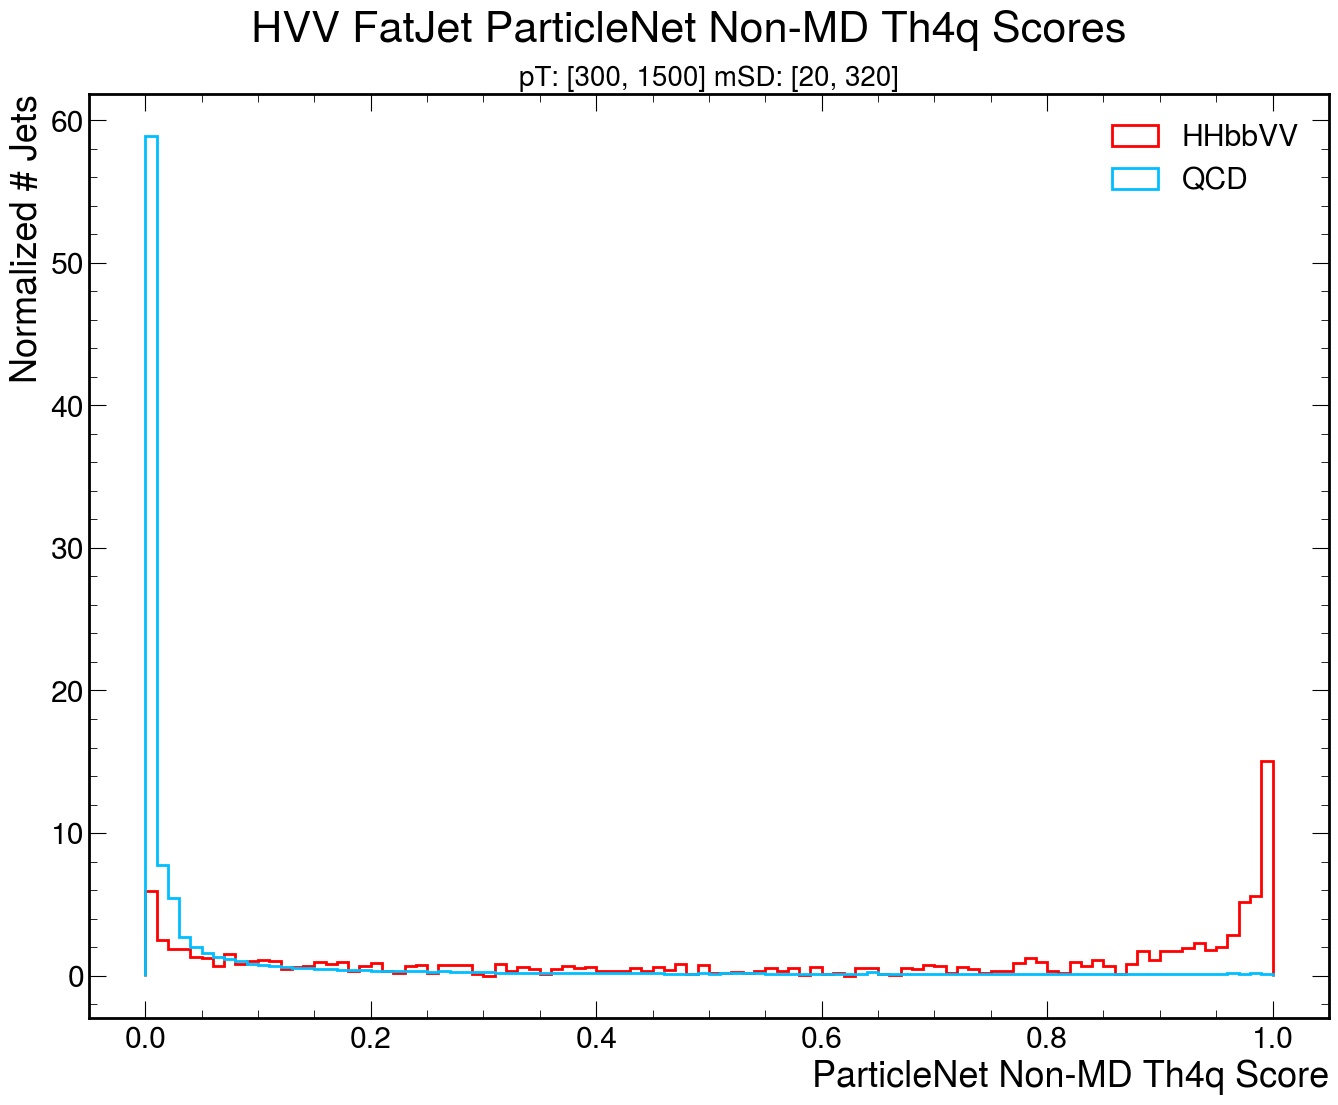

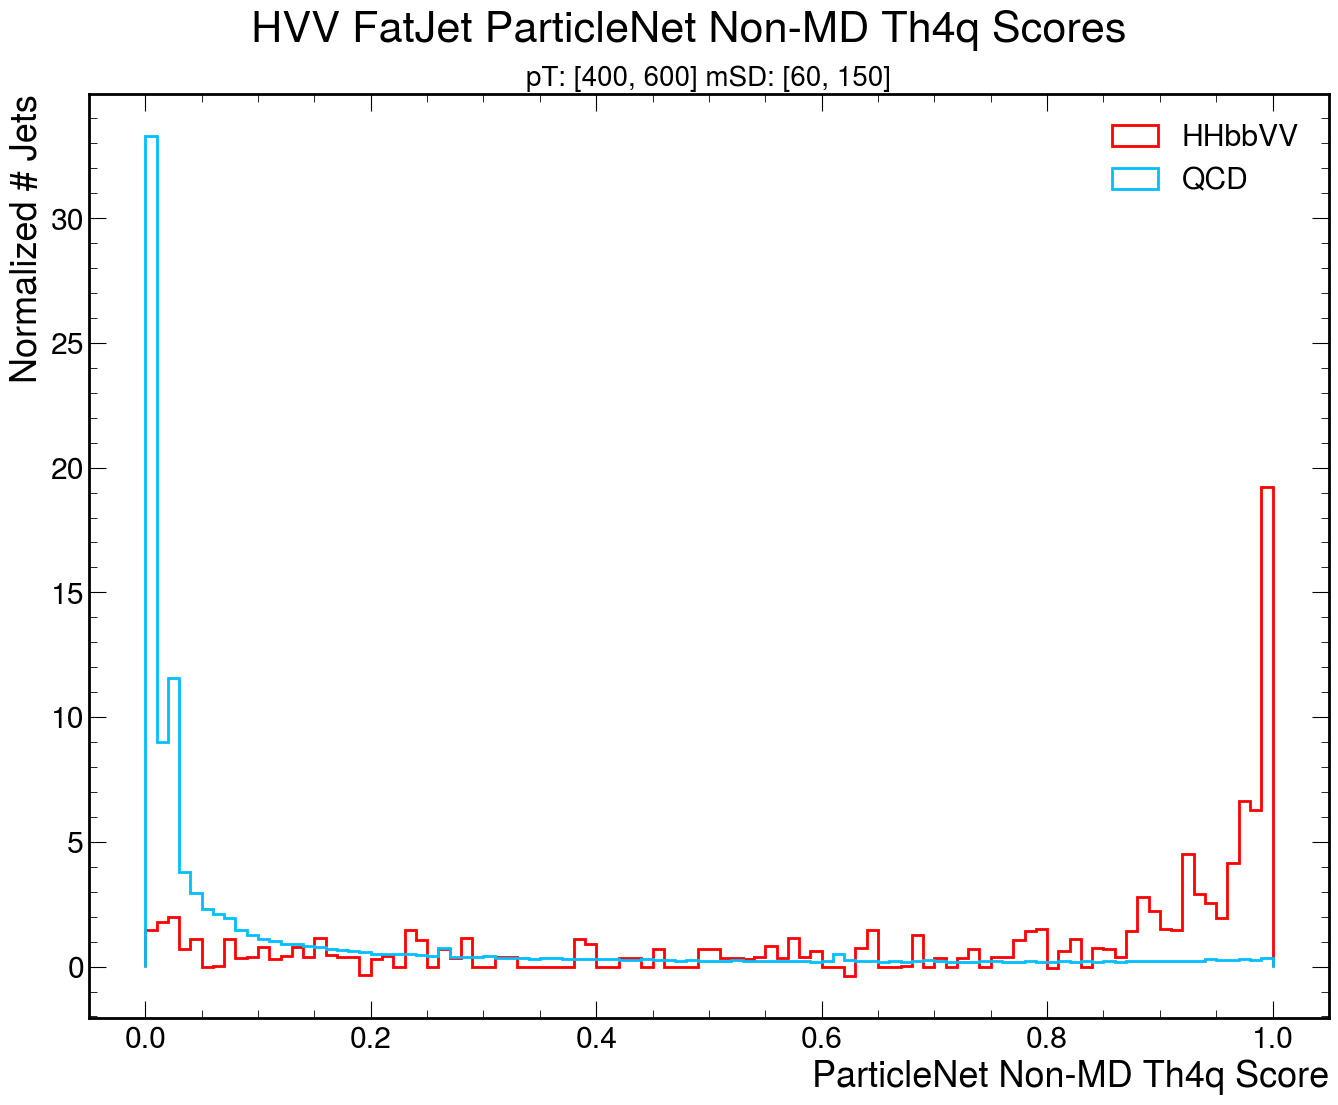

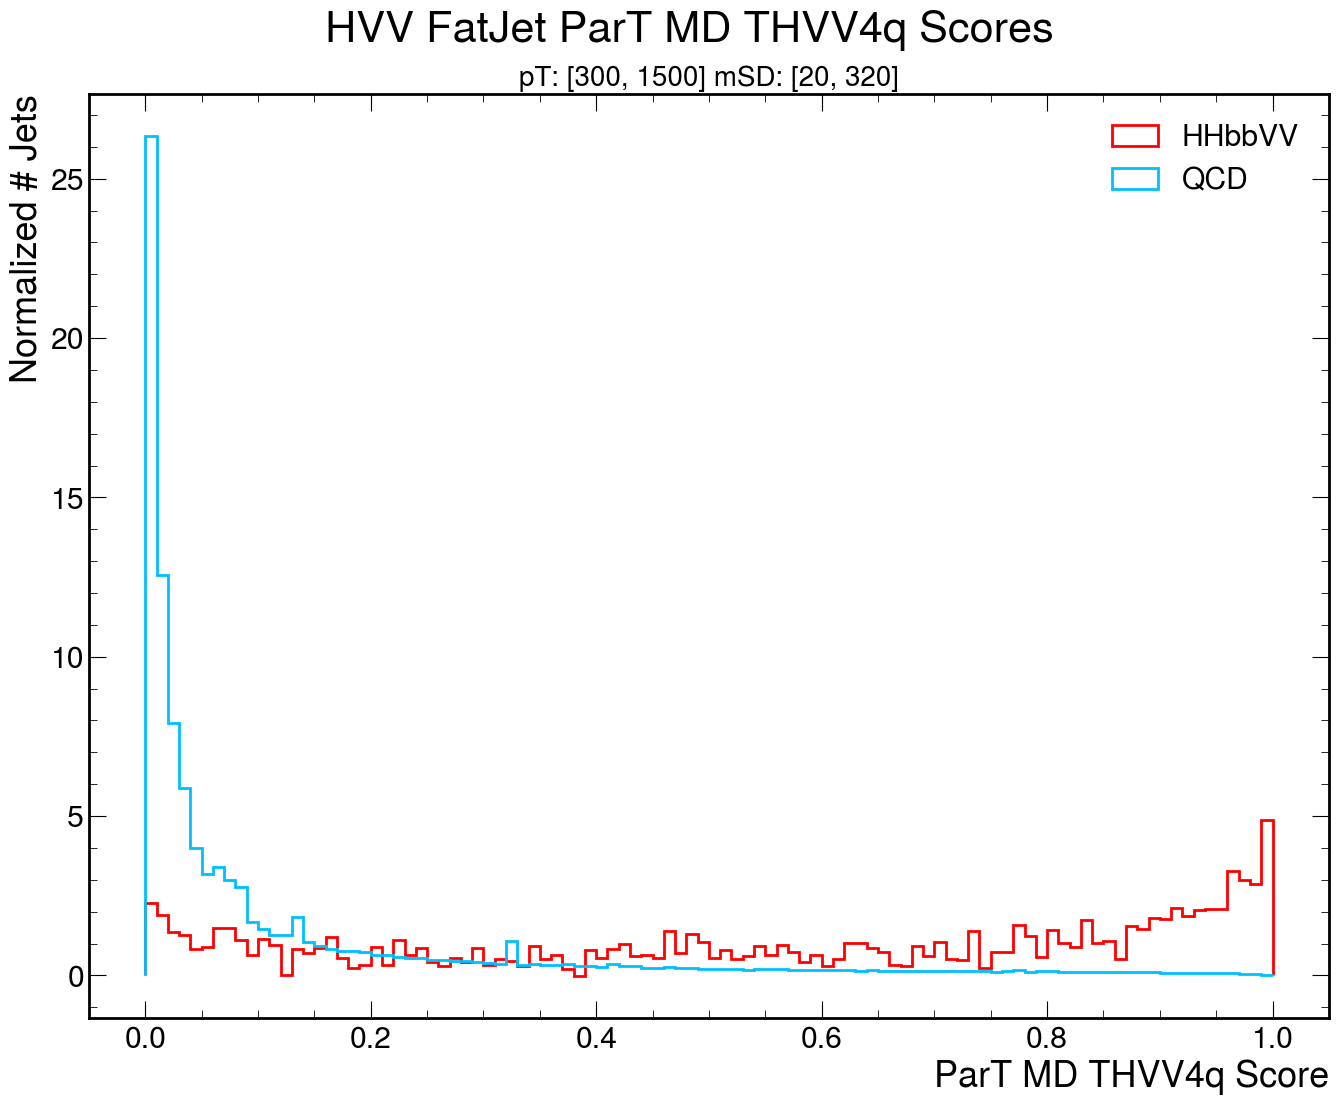

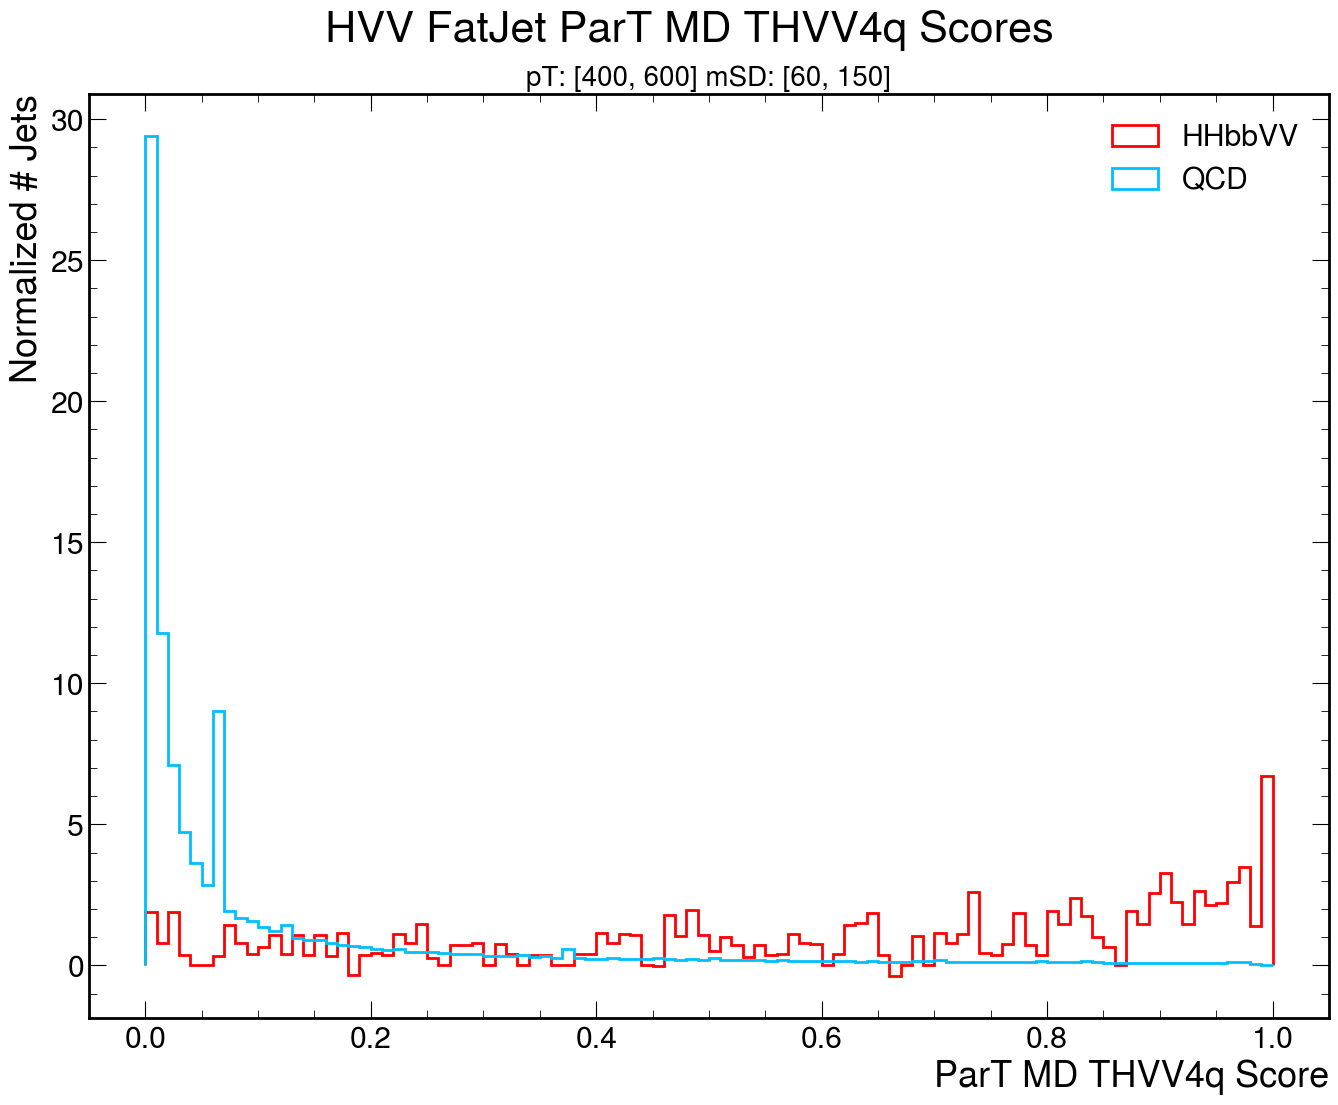

In [32]:
plot_vars = {
    "th4q": {
        "title": "ParticleNet Non-MD Th4q",
        "score_label": "ak8FatJetParticleNet_Th4q",
        "colour": "orange",
    },
    "thvv4q": {
        "title": "ParT MD THVV4q",
        "score_label": "ak8FatJetParTMD_THWW4q",
        "colour": "green",
    },
}

samples = {"qcd": "QCD", "HHbbVV": "HHbbVV"}

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)
hep.style.use("CMS")

for t, pvars in plot_vars.items():
    for cutstr in cut_labels:
        plt.figure(figsize=(16, 12))
        plt.suptitle(f"HVV FatJet {pvars['title']} Scores", y=0.95)
        plt.title(cut_labels[cutstr], fontsize=20)

        for sample, colour, skip in [("HHbbVV", "red", 1), ("QCD", "deepskyblue", 4)]:
            _ = plt.hist(
                events_dict[sample][pvars["score_label"]][cuts_dict[sample][cutstr]][::skip],
                histtype="step",
                bins=np.linspace(0, 1, 101),
                label=f"{sample}",
                linewidth=2,
                color=colour,
                density=True,
                weights=events_dict[sample]["weight"][cuts_dict[sample][cutstr]][::skip],
            )

        plt.ylabel("Normalized # Jets")
        plt.xlabel(f"{pvars['title']} Score")
        plt.legend()
        plt.savefig(
            f"{plot_dir}/{t}_hist_{cutstr}.pdf",
            bbox_inches="tight",
        )

### ROCs

In [17]:
from sklearn.metrics import roc_curve, auc

rocs = {}
sig_key = "HHbbVV"
bg_key = "QCD"
bg_skip = 4

for cutstr in cut_labels:
    rocs[cutstr] = {}

    sig_cut = cuts_dict[sig_key][cutstr]
    bg_cut = cuts_dict[bg_key][cutstr]

    y_true = np.concatenate(
        [
            np.ones(np.sum(sig_cut)),
            np.zeros(int(np.ceil(np.sum(bg_cut) / bg_skip))),
        ]
    )

    weights = np.concatenate(
        (events_dict[sig_key]["weight"][sig_cut], events_dict[bg_key]["weight"][bg_cut][::bg_skip])
    )

    for t, pvars in plot_vars.items():
        print(t)
        score_label = pvars["score_label"]
        scores = np.concatenate(
            (
                events_dict[sig_key][score_label][sig_cut],
                events_dict[bg_key][score_label][bg_cut][::bg_skip],
            )
        )
        fpr, tpr, thresholds = roc_curve(y_true, scores, sample_weight=weights)
        rocs[cutstr][t] = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": auc(fpr, tpr)}

th4q
thvv4q
th4q
thvv4q


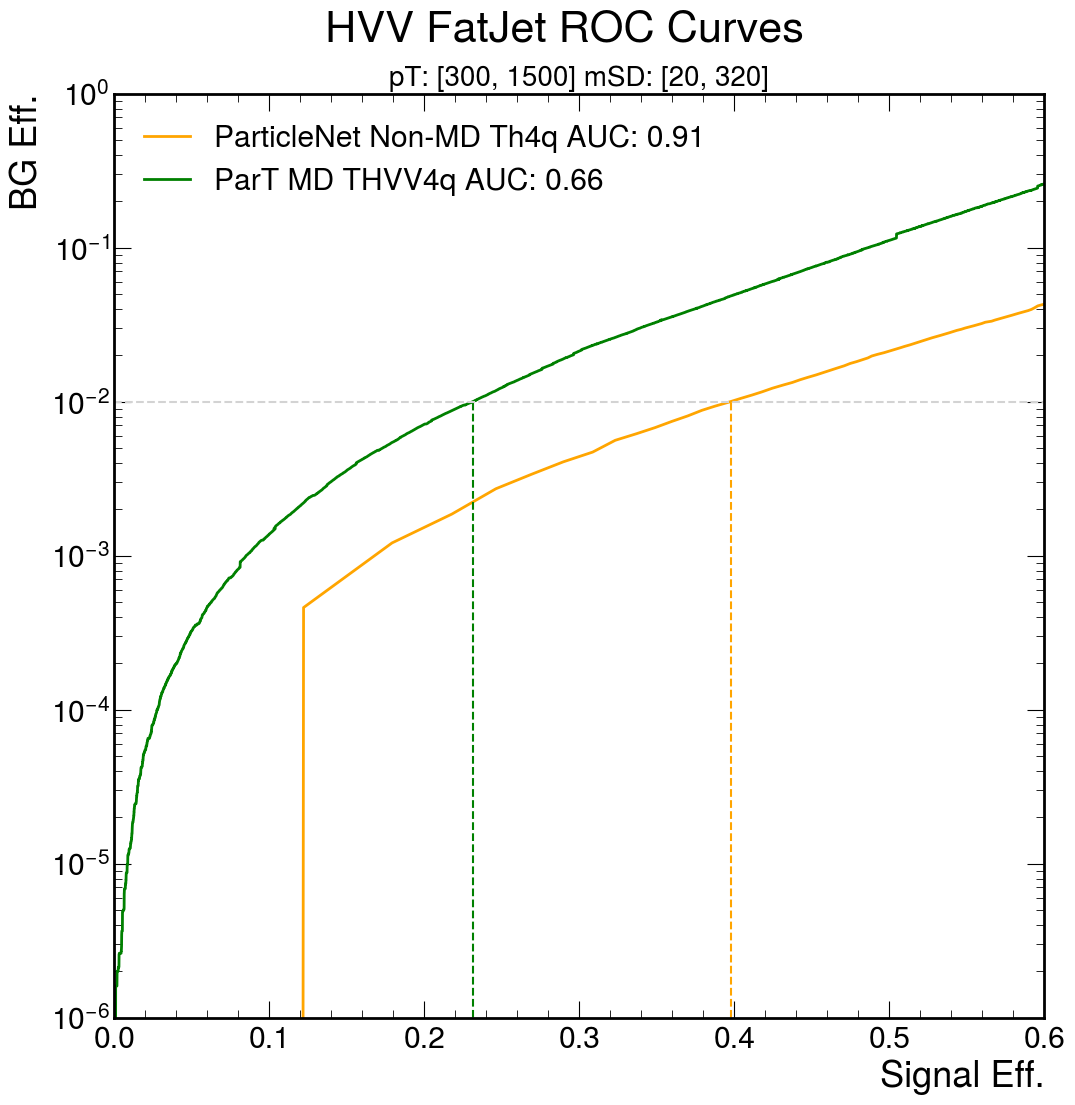

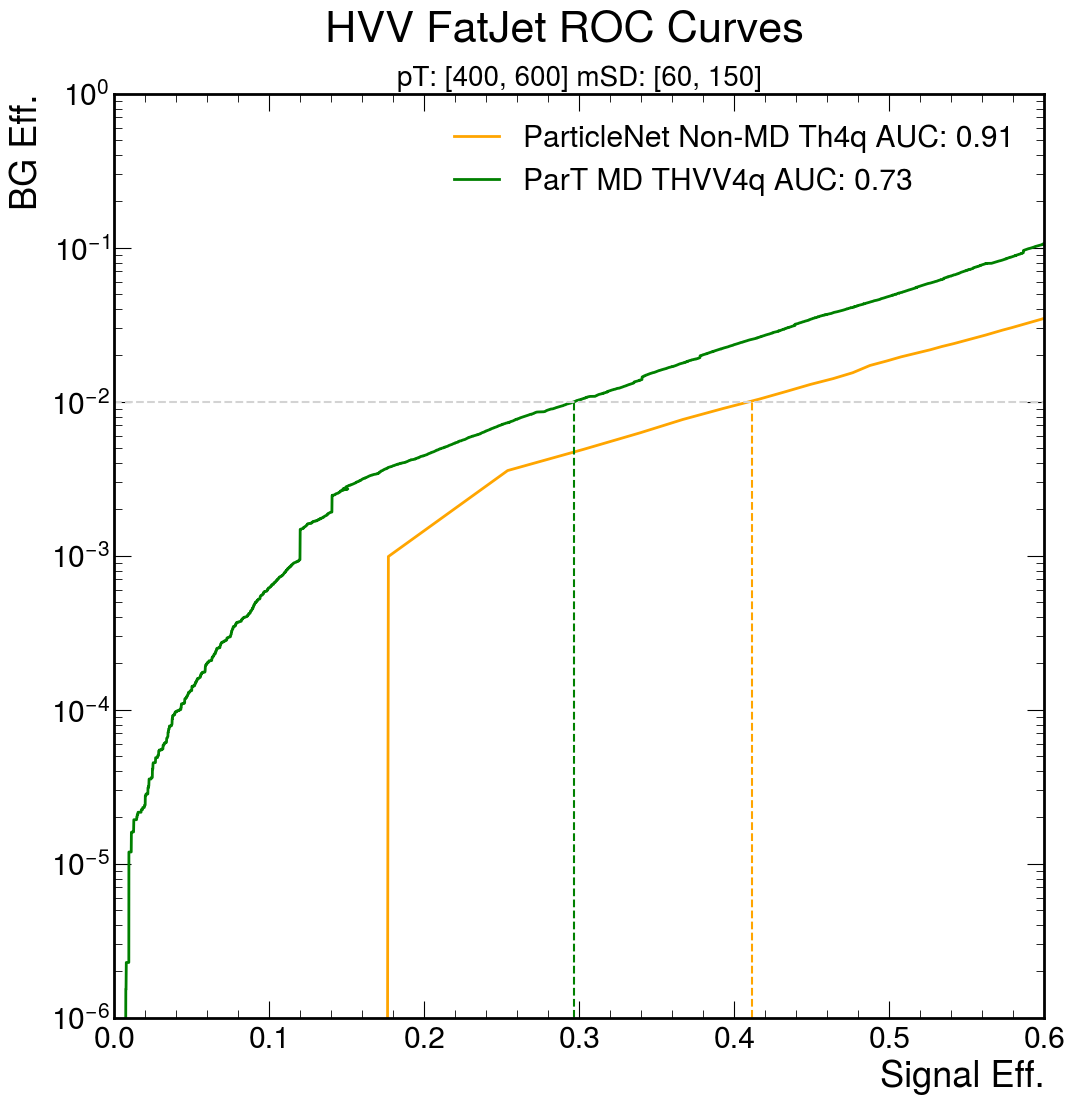

In [18]:
xlim = [0, 0.6]
ylim = [1e-6, 1]

for cutstr in cut_labels:
    plt.figure(figsize=(12, 12))
    for t, pvars in plot_vars.items():
        plt.plot(
            rocs[cutstr][t]["tpr"][::10],
            rocs[cutstr][t]["fpr"][::10],
            label=f"{pvars['title']} AUC: {rocs[cutstr][t]['auc']:.2f}",
            linewidth=2,
            color=pvars["colour"],
        )
        plt.vlines(
            x=rocs[cutstr][t]["tpr"][np.searchsorted(rocs[cutstr][t]["fpr"], 0.01)],
            ymin=0,
            ymax=0.01,
            colors=pvars["colour"],
            linestyles="dashed",
        )
    plt.hlines(y=0.01, xmin=0, xmax=1, colors="lightgrey", linestyles="dashed")
    plt.yscale("log")
    plt.xlabel("Signal Eff.")
    plt.ylabel("BG Eff.")
    plt.suptitle("HVV FatJet ROC Curves", y=0.95)
    plt.title(cut_labels[cutstr], fontsize=20)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.legend()
    plt.savefig(f"{plot_dir}/roccurve_{cutstr}.pdf", bbox_inches="tight")
